In [1]:
import numpy as np
import torch

/home/jaehyung/anaconda3/envs/human/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Statistics

In [2]:
from scipy import io

In [278]:
attributes = io.loadmat('./SUNAttributeDB/attributes.mat')
attributeLabels_continuous = io.loadmat('./SUNAttributeDB/attributeLabels_continuous.mat')
images = io.loadmat('./SUNAttributeDB/images.mat')

In [279]:
attributes_list = []

for i in range(len(attributes['attributes'])):
    attributes_list.append(attributes['attributes'][:, 0][i][0])

In [75]:
n_class = attributes['attributes'].shape[0]
n_samples = images['images'].shape[0]

In [14]:
annotations = attributeLabels_continuous['labels_cv']

In [20]:
annotations_onehot = (annotations > 0.5).astype(np.int64)

In [43]:
probs = 1 / annotations_onehot.sum(axis=0)
probs /= probs.sum()

In [61]:
samples = torch.distributions.categorical.Categorical(probs=torch.Tensor(probs))

In [72]:
from tqdm import tqdm

In [219]:
selected_labels = []
selected_indices = [] 
selected_votes = [] 
        
for i in tqdm(range(n_samples)):
    annotations_onehot_i = annotations_onehot[i]
    if annotations_onehot_i.sum() == 0:
        continue
    else:
        non_zero_idx = annotations_onehot_i.nonzero()[0]
        probs = torch.zeros(n_class)
        for k in range(n_class):
            if annotations_onehot_i[k] == 0:
                continue
            else:
                probs[k] = 1 / annotations[i][k]
        probs /= probs.sum()
        sampler = torch.distributions.categorical.Categorical(probs=torch.Tensor(probs))

        sample = sampler.sample()
        while int(sample) not in non_zero_idx:
            sample = sampler.sample()
            
        selected_labels.append(sample)
        selected_indices.append(i)
        selected_votes.append(annotations[i][sample])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14340/14340 [00:02<00:00, 7047.64it/s]


In [224]:
n_classes = torch.zeros(n_class).long()
selected_labels = torch.LongTensor(selected_labels)

for k in range(n_class):
    n_classes[k] = (selected_labels == k).sum()
print(n_classes)

tensor([  82,   97,   67,   98,   24,  117,   61,   66,   79,   82,   38,   41,
          36,   48,   62,   20,   62,   17,  110,  107,   53,   92,   69,   57,
          59,   11,   69,   46,   13,   71,   14,  170,   77,   23,   44,   50,
          48,   79,   46,   14,  185,  187,  204,   96,  211,  186,   23,   79,
          92,   55,   62,   69,   45,   67,  239,   57,  307,   54,  102,  207,
          33,   83,   95,   23,  229,   21,   54,   34,   49,   23,   35,  193,
          13,    8,  970,  272,  424,  112,  193,  103,   28,   95,  166,   66,
          39,   83,   55,  199, 1494,  672,   75,  937,  194, 1491,  103,  231,
         122,   58,   92,   29,  129,   46])


In [225]:
n_votes = torch.zeros(2).long()
selected_votes = torch.Tensor(selected_votes)

n_votes[0] = (selected_votes == 2/3).sum()
n_votes[1] = (selected_votes == 3/3).sum()

print(n_votes)

tensor([10109,  4208])


In [226]:
selected_indices = torch.LongTensor(selected_indices)

### Generating txt files for loading

In [281]:
pths = images['images'][:, 0]#[selected_indices]

In [229]:
n_samples_split = torch.zeros(3)
f_train = open("./dataset/SUN_train.txt", 'w')
f_val = open("./dataset/SUN_val.txt", 'w')
f_test = open("./dataset/SUN_test.txt", 'w')

for k in range(n_class):
    k_indices = (selected_labels == k).nonzero()[:, 0]
    n_k = len(k_indices)
    n_train, n_test = int(0.8 * n_k), int(0.9 * n_k)
    
    train_indices = k_indices[:n_train]
    val_indices = k_indices[n_train:n_test]
    test_indices = k_indices[n_test:]
    
    for idx in train_indices:
        f_train.write("{} {} {} \n".format(str(pths[idx])[2:-2], selected_labels[idx], selected_votes[idx]))
    for idx in val_indices:
        f_val.write("{} {} {} \n".format(str(pths[idx])[2:-2], selected_labels[idx], selected_votes[idx]))
    for idx in test_indices:
        f_test.write("{} {} {} \n".format(str(pths[idx])[2:-2], selected_labels[idx], selected_votes[idx]))
        
    n_samples_split[0] += len(train_indices)
    n_samples_split[1] += len(val_indices)
    n_samples_split[2] += len(test_indices)

f_train.close()
f_val.close()
f_test.close()

## Loader

In [125]:
import torch.utils.data as data
from PIL import Image
import os
import json
from torchvision import transforms, utils, datasets
import random
import numpy as np

from torch import cuda
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import WeightedRandomSampler

image_size = 128

# Parameters for data
cifar10_mean = (0.5, 0.5, 0.5) # equals np.mean(train_set.train_data, axis=(0,1,2))/255
cifar10_std = (0.5, 0.5, 0.5) # equals np.std(train_set.train_data, axis=(0,1,2))/255

# Augmentations.
transform_train = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop(image_size, padding=int(image_size / 8)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

transform_val = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])


In [130]:
class Transform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, inp):
        out1 = self.transform(inp)
        return out1

class SUN_Dataset(Dataset):
    def __init__(self, root, txt, transform=None):
        self.img_path = []
        self.labels = []
        self.votes = []
        self.transform = transform
        with open(txt) as f:
            for line in f:
                self.img_path.append(os.path.join(root, line.split()[0]))
                self.labels.append(int(line.split()[1]))
                self.votes.append(float(line.split()[2]))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        path = self.img_path[index]
        label = self.labels[index]

        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, label, index

def get_sun_loader(batch_size, num_workers=16):
    txt_train = './SUN_train.txt'
    txt_val = './SUN_val.txt'
    txt_test = './SUN_test.txt'

    data_root = '/home/jaehyung/workspace/prev_projects/adv_pref_HITL/images'

    set_train = SUN_Dataset(data_root, txt_train, transform_train)
    set_val = SUN_Dataset(data_root, txt_val, transform_val)
    set_test = SUN_Dataset(data_root, txt_test, transform_val)

    train_loader = DataLoader(set_train, batch_size, shuffle=True, num_workers=num_workers, pin_memory=cuda.is_available())
    val_loader = DataLoader(set_val, batch_size, shuffle=False, num_workers=num_workers, pin_memory=cuda.is_available())
    test_loader = DataLoader(set_test, batch_size, shuffle=False, num_workers=num_workers, pin_memory=cuda.is_available())

    return train_loader, val_loader, test_loader

In [131]:
a, b, c = get_sun_loader(16)

In [133]:
for batch_idx, (inputs, targets, indices) in enumerate(a):
    print(inputs.shape)
    break

torch.Size([16, 3, 128, 128])


In [134]:
from PIL import Image

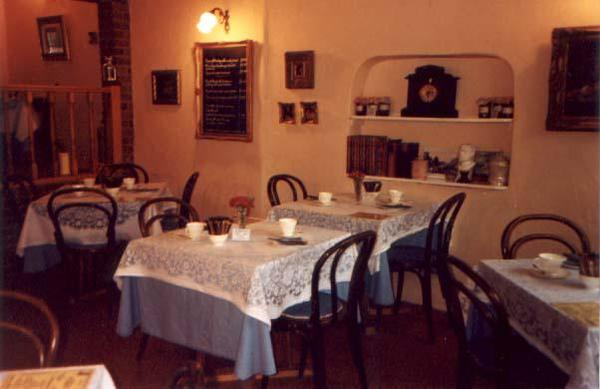

In [198]:
Image.open('images/' + str(pths[12365])[2:-2])

In [153]:
import glob

In [156]:
rootdir = './images'
n_folder = 0
for path in glob.glob(f'{rootdir}/*/**/', recursive=True):
    print(path)
    n_folder += 1

./images/i/
./images/i/irrigation_ditch/
./images/i/iceberg/
./images/i/ice_skating_rink/
./images/i/ice_skating_rink/outdoor/
./images/i/ice_skating_rink/indoor/
./images/i/islet/
./images/i/ice_shelf/
./images/i/industrial_area/
./images/i/igloo/
./images/i/ice_floe/
./images/i/ice_cream_parlor/
./images/i/inn/
./images/i/inn/outdoor/
./images/i/inn/indoor/
./images/i/industrial_park/
./images/v/
./images/v/vestry/
./images/v/volleyball_court/
./images/v/volleyball_court/outdoor/
./images/v/volleyball_court/indoor/
./images/v/videostore/
./images/v/volcano/
./images/v/valley/
./images/v/velodrome/
./images/v/velodrome/outdoor/
./images/v/velodrome/indoor/
./images/v/vineyard/
./images/v/village/
./images/v/van_interior/
./images/v/veranda/
./images/v/vegetable_garden/
./images/v/veterinarians_office/
./images/v/voting_booth/
./images/v/viaduct/
./images/v/ventilation_shaft/
./images/l/
./images/l/laundromat/
./images/l/landing_deck/
./images/l/limousine_interior/
./images/l/lagoon/
.

In [157]:
n_folder

978

# Binary Split

In [252]:
annotations_all = (annotations == 3/3).astype(np.int64)
annotations_ambig = (annotations == 2/3).astype(np.int64)
annotations_minor = (annotations == 1/3).astype(np.int64)
annotations_zero = (annotations == 0).astype(np.int64)

In [236]:
annotations_all.sum(axis=0)

array([ 310,  261,  144,  211,   51,  151,  264,  222,  240,  145,   63,
         51,   43,  123,  251,   37,  137,   25,  195,  186,   55,  237,
        239,  136,  116,   38,  150,   96,   24,  182,   52,  288,   79,
         44,   40,   73,   99,  146,   85,   53,  844, 1005,  774,  316,
        873,  501,  108,  274,  118,  169,   63,  135,   33,   38,  312,
         67,  541,   27,  133,  444,  124,  189,  266,   15,  256,   59,
        195,  123,  175,   56,  171,  823,   37,   28, 3019,  720,  762,
        106,  235,   62,   40,  102,  294,  113,   50,  130,  204,  817,
       3979, 2808,  117, 3120,  736, 3014,  268,  260,  144,   68,  149,
         14,  134,   73])

In [237]:
annotations_ambig.sum(axis=0)

array([ 362,  486,  463,  488,  190,  774,  486,  416,  631,  451,  175,
        243,  164,  312,  337,  132,  354,   57,  516,  566,  259,  393,
        316,  315,  439,   70,  291,  235,   61,  266,   66,  744,  309,
        142,  223,  204,  295,  421,  257,   56,  927,  695, 1114,  592,
        962, 1085,  106,  361,  514,  295,  261,  290,  152,  355,  941,
        271, 1171,  270,  425,  917,  227,  405,  595,  120,  889,  112,
        218,  154,  344,  102,  114,  743,   44,   22, 3690, 1746, 1347,
        525,  821,  540,  114,  577,  945,  304,  230,  746,  184,  762,
       4433, 2733,  387, 1827,  800, 4595,  555,  938,  678,  298,  361,
        130,  719,  297])

In [253]:
annotations_minor.sum(axis=0)

array([ 460,  973,  985, 1190,  812, 2757, 1015, 1138, 1189, 1309,  598,
       1205,  560,  573,  543,  740,  889,  452, 1536, 1541, 1045,  592,
        459,  778, 1302,  330,  585,  604,  278,  460,  208, 1839, 1032,
        525,  975,  396, 1198, 1183,  999,  148, 1283,  975, 1510, 1135,
       1303, 1426,  331,  831, 1642,  872,  906, 1017,  922, 1756, 2503,
       1077, 2214, 1494, 1851, 1776,  691, 1029, 1715, 1088, 2360,  356,
        362,  412,  556,  272,  166,  945,   76,   91, 2474, 2815, 1789,
       1642, 2438, 2603,  850, 1946, 4037, 1089, 1151, 3184,  828,  886,
       3466, 1883, 1420, 1032, 1112, 3433, 1154, 2733, 2792, 1154, 1055,
       1017, 2560, 1543])

In [254]:
annotations_zero.sum(axis=0)

array([13208, 12620, 12748, 12451, 13287, 10658, 12575, 12564, 12280,
       12435, 13504, 12841, 13573, 13332, 13209, 13431, 12960, 13806,
       12093, 12047, 12981, 13118, 13326, 13111, 12483, 13902, 13314,
       13405, 13977, 13432, 14014, 11469, 12920, 13629, 13102, 13667,
       12748, 12590, 12999, 14083, 11286, 11665, 10942, 12297, 11202,
       11328, 13795, 12874, 12066, 13004, 13110, 12898, 13233, 12191,
       10584, 12925, 10414, 12549, 11931, 11203, 13298, 12717, 11764,
       13117, 10835, 13813, 13565, 13651, 13265, 13910, 13889, 11829,
       14183, 14199,  5157,  9059, 10442, 12067, 10846, 11135, 13336,
       11715,  9064, 12834, 12909, 10280, 13124, 11875,  2462,  6916,
       12416,  8361, 11692,  3298, 12363, 10409, 10726, 12820, 12775,
       13179, 10927, 12427])

In [242]:
((annotations_all.sum(axis=0) >= 1000) * (annotations_ambig.sum(axis=0) >= 1000)).nonzero()

(array([74, 88, 89, 91, 93]),)

In [436]:
attributes_list[93]

'no horizon'

### construction

In [401]:
selected_class = 93

In [402]:
most_positive = (annotations[:, selected_class] == 1).nonzero()[0]
rand_idx = np.random.permutation(len(most_positive))[:1000]
most_positive = most_positive[rand_idx]

In [403]:
less_positive = (annotations[:, selected_class] == 2/3).nonzero()[0]
rand_idx = np.random.permutation(len(less_positive))[:1000]
less_positive = less_positive[rand_idx]

In [404]:
negative = (annotations[:, selected_class] <= 1/3).nonzero()[0]
rand_idx = np.random.permutation(len(negative))[:2000]
negative = negative[rand_idx]

In [405]:
all_indices = np.concatenate([most_positive, less_positive, negative], axis=0)

In [406]:
n_samples_split = torch.zeros(3)
f_train = open("./dataset/SUN_train_{}.txt".format(selected_class), 'w')
f_val = open("./dataset/SUN_val_{}.txt".format(selected_class), 'w')
f_test = open("./dataset/SUN_test_{}.txt".format(selected_class), 'w')

split(pths, most_positive, 1, annotations, selected_class, f_train, f_val, f_test)
split(pths, less_positive, 1, annotations, selected_class, f_train, f_val, f_test)
split(pths, negative, 0, annotations, selected_class, f_train, f_val, f_test)

f_train.close()
f_val.close()
f_test.close()

In [407]:
def split(pths, indices, label, annotations, cls, f_train, f_val, f_test):
    n_k = len(indices)
    n_train, n_test = int(0.8 * n_k), int(0.9 * n_k)

    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_test]
    test_indices = indices[n_test:]

    for idx in train_indices:
        f_train.write("{} {} {} \n".format(str(pths[idx])[2:-2], label, annotations[idx, cls]))
    for idx in val_indices:
        f_val.write("{} {} {} \n".format(str(pths[idx])[2:-2], label, annotations[idx, cls]))
    for idx in test_indices:
        f_test.write("{} {} {} \n".format(str(pths[idx])[2:-2], label, annotations[idx, cls]))

In [408]:
f_train = open("./dataset/SUN_train_{}.txt".format(selected_class), 'r')
f_train = f_train.readlines()
train_labels, train_votes = [], []

In [409]:
for i in range(len(f_train)):
    _, label, vote = f_train[i].split()
    label = int(label)
    vote = float(vote)
    train_labels.append(label)
    train_votes.append(vote)
train_labels = torch.LongTensor(train_labels)
train_votes = torch.Tensor(train_votes)

In [411]:
soft_labels = torch.zeros(len(f_train), 2)
    
for i in range(len(f_train)):
    soft_labels[i, 1] =  train_votes[i]
    soft_labels[i, 0] =  1 - train_votes[i]

In [413]:
np.save('./dataset/SUN_{}_soft_labels.npy'.format(selected_class), soft_labels.numpy())

In [414]:
label_str = ['positive', 'negative']
indices_all = {}
indices_all[label_str[0]] = list((train_labels == 1).float().nonzero()[:, 0].numpy())
indices_all[label_str[1]] = list((train_labels == 0).float().nonzero()[:, 0].numpy())

In [415]:
human_preference_all = {}

pref = train_votes[indices_all['positive']]
mat = pref.unsqueeze(1) - pref.unsqueeze(0)
convert = 2 * (mat == 0) + 1 * (mat > 0) + torch.eye(len(pref))

human_preference_all['positive'] = convert

pref = -1 * train_votes[indices_all['negative']]
mat = pref.unsqueeze(1) - pref.unsqueeze(0)
convert = 2 * (mat == 0) + 1 * (mat > 0) + torch.eye(len(pref))

human_preference_all['negative'] = convert

In [417]:
rand_idx_pref = torch.zeros(20, len(train_votes), 2).long()

for i in range(len(train_votes)):
    candidate_idx = indices_all[label_str[1 - train_labels[i]]]
    i_loc = candidate_idx.index(i)

    for k in range(20):
        rand_idx = np.random.randint(0, len(candidate_idx))
        while i_loc == rand_idx:
            rand_idx = np.random.randint(0, len(candidate_idx))

        rand_idx_pref[k, i, 0] = candidate_idx[rand_idx]
        rand_idx_pref[k, i, 1] = human_preference_all[label_str[1 - train_labels[i]]][i_loc, rand_idx]

In [418]:
np.save('./dataset/SUN_{}_idx_pref_random20.npy'.format(selected_class), rand_idx_pref.numpy())

In [419]:
pref_labels = np.load('./dataset/SUN_{}_idx_pref_random20.npy'.format(74))